Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [87]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy, copy
from tqdm import tqdm
from matplotlib import pyplot as plt
from dataclasses import dataclass
import numpy as np


## The *Nim* and *Nimply* classes

In [91]:
Nimply = namedtuple("Nimply", "row, num_objects")
N_ROWS = 5
GAME_DIMENSION = N_ROWS
ELEMENT_PER_ROW = 2*N_ROWS - 1
POPULATION_SIZE = 5             # μ
OFFSPRING_SIZE = 20             # λ
MUTATION_STEP = 2               # σ
NUM_GENERATIONS = 50


In [89]:
@dataclass
class Individual:
    genotype: list[list[float], list[list[float]]]
    fitness: float

In [90]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) strategies 

In [92]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [5]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [93]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [94]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [ ]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


## ES (1 + λ)

In [106]:
def evolve_Individual(ind: Individual) -> list:
    new_population = []
    for _ in range(OFFSPRING_SIZE):
        offspring = deepcopy(ind)
        mutation_gene_1 = np.random.normal(loc=0, scale=2, size=(N_ROWS))
        new_gene_1 = np.abs(offspring.genotype[0] + mutation_gene_1)
        tot = np.sum(new_gene_1)
        offspring.genotype[0]=np.array(new_gene_1/tot)
        # - - - - - - #
        mutation_gene_2 = np.random.normal(loc=0, scale=2, size=(N_ROWS, ELEMENT_PER_ROW))
        for r in range(1, N_ROWS+1):
            for i in range(ELEMENT_PER_ROW):
                if i>=2*r-1:
                    mutation_gene_2[r-1, i]=0
        new_gene_2 = np.abs(mutation_gene_2 + ind.genotype[1])
        tot = np.reshape(np.sum(new_gene_2, axis=1), (N_ROWS, 1))
        offspring.genotype[1]=np.array(new_gene_2/tot)

        new_population.append(offspring)

    return new_population

In [105]:
first_player = Individual(
    genotype=[
        np.array([1/N_ROWS for _ in range(N_ROWS)]), 
        np.array([[1/(2*r-1) if i<2*r-1 else 0 for i in range(ELEMENT_PER_ROW) ] for r in range(1, N_ROWS+1)])
        ],
    fitness = 0.0)    

  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:
Best Agent of 1° generation won 35.0 over 100 matches

INFO:root:
Best Agent util now have won 35.0 over 100 matches

  2%|▏         | 1/50 [00:13<11:21, 13.91s/it]INFO:root:
Best Agent of 2° generation won 37.0 over 100 matches

INFO:root:
Best Agent util now have won 37.0 over 100 matches

  4%|▍         | 2/50 [00:27<10:56, 13.68s/it]INFO:root:
Best Agent of 3° generation won 36.0 over 100 matches

INFO:root:
Best Agent util now have won 37.0 over 100 matches

  6%|▌         | 3/50 [00:41<10:46, 13.75s/it]INFO:root:
Best Agent of 4° generation won 37.0 over 100 matches

INFO:root:
Best Agent util now have won 37.0 over 100 matches

  8%|▊         | 4/50 [00:55<10:35, 13.82s/it]INFO:root:
Best Agent of 5° generation won 33.0 over 100 matches

INFO:root:
Best Agent util now have won 37.0 over 100 matches

 10%|█         | 5/50 [01:09<10:28, 13.96s/it]INFO:root:
Best Agent of 6° generation won 39.0 over 100 matches

INFO:root:
Best Agent

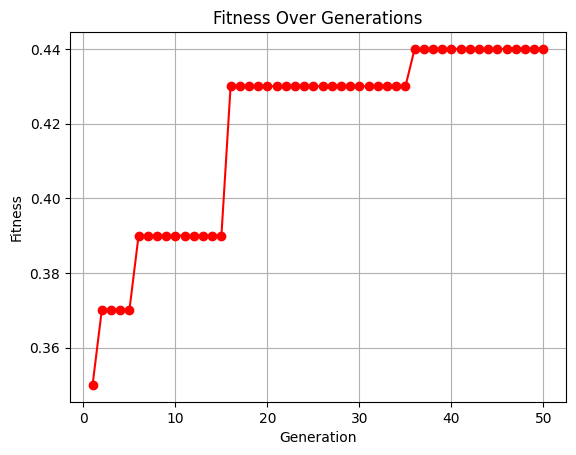

In [107]:
logging.getLogger().setLevel(logging.INFO)
solution = first_player
history = list()
best_agent = deepcopy(solution)
# history.append(solution)

opponent = pure_random

for n in tqdm(range(NUM_GENERATIONS)):
    offsprings = evolve_Individual(solution)
    offsprings.append(solution)

    for player in offsprings:
        player.fitness = Evaluation((player, opponent))
    
    solution = max(offsprings, key=lambda i:i.fitness)
    logging.info(f"\nBest Agent of {n+1}° generation won {round(solution.fitness*100, 2)} over 100 matches\n")
    if best_agent.fitness < solution.fitness:
        best_agent = deepcopy(solution)
    history.append(best_agent.fitness)
    logging.info(f"\nBest Agent util now have won {round(best_agent.fitness*100, 2)} over 100 matches\n")


logging.info(f"\nBest solution: {best_agent.fitness}\nRows choice: {best_agent.genotype[0]}\nElement choice: {best_agent.genotype[1]}")

history = np.array(history)
generations = list(range(1, 50 + 1))

plt.plot(generations, history, marker='o', linestyle='-', color='r')
plt.title('Fitness Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.grid(True)
plt.show()

## ES (μ + λ)

In [112]:
first_population = []

for m in range(5):
    gene_1 = np.array([random.random() for _ in range(N_ROWS)])
    gene_2 = np.array([[random.random() if i<2*r-1 else 0 for i in range(ELEMENT_PER_ROW) ] for r in range(1, N_ROWS+1)])

    first_population.append(Individual(
        genotype=[
            gene_1/np.sum(gene_1), 
            gene_2/np.reshape(np.sum(gene_2, axis=1), (N_ROWS, 1))
            ],
        fitness = 0.0))

In [113]:
def mutate_Individual(ind: Individual) -> list:
    offspring = deepcopy(ind)
    mutation_gene_1 = np.random.normal(loc=0, scale=2, size=(N_ROWS))
    new_gene_1 = np.abs(offspring.genotype[0] + mutation_gene_1)
    tot = np.sum(new_gene_1)
    offspring.genotype[0]=np.array(new_gene_1/tot)
    # - - - - - - #
    mutation_gene_2 = np.random.normal(loc=0, scale=2, size=(N_ROWS, ELEMENT_PER_ROW))
    for r in range(1, N_ROWS+1):
        for i in range(ELEMENT_PER_ROW):
            if i>=2*r-1:
                mutation_gene_2[r-1, i]=0
    new_gene_2 = np.abs(mutation_gene_2 + ind.genotype[1])
    tot = np.reshape(np.sum(new_gene_2, axis=1), (N_ROWS, 1))
    offspring.genotype[1]=np.array(new_gene_2/tot)

    return offspring

  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:
Best Agent of 1° generation won 34.0 over 100 matches

  2%|▏         | 1/50 [00:13<11:02, 13.52s/it]INFO:root:
Best Agent of 2° generation won 34.0 over 100 matches

  4%|▍         | 2/50 [00:26<10:32, 13.18s/it]INFO:root:
Best Agent of 3° generation won 37.0 over 100 matches

  6%|▌         | 3/50 [00:39<10:21, 13.23s/it]INFO:root:
Best Agent of 4° generation won 37.0 over 100 matches

  8%|▊         | 4/50 [00:52<10:06, 13.19s/it]INFO:root:
Best Agent of 5° generation won 44.0 over 100 matches

 10%|█         | 5/50 [01:06<09:54, 13.22s/it]INFO:root:
Best Agent of 6° generation won 44.0 over 100 matches

 12%|█▏        | 6/50 [01:19<09:37, 13.13s/it]INFO:root:
Best Agent of 7° generation won 44.0 over 100 matches

 14%|█▍        | 7/50 [01:32<09:23, 13.12s/it]INFO:root:
Best Agent of 8° generation won 44.0 over 100 matches

 16%|█▌        | 8/50 [01:45<09:13, 13.17s/it]INFO:root:
Best Agent of 9° generation won 44.0 over 100 matches



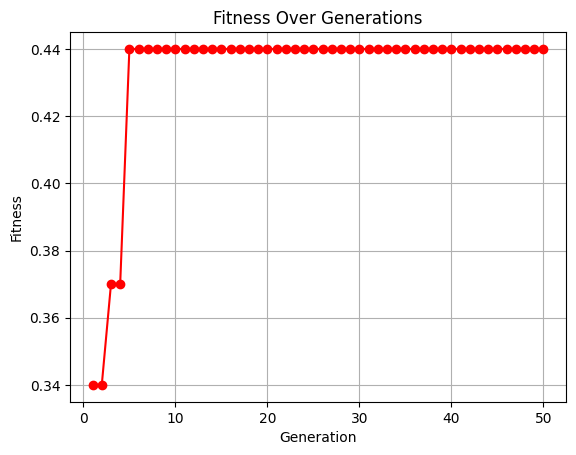

In [114]:
logging.getLogger().setLevel(logging.INFO)

current_population = first_population
history = list()
best_so_far = deepcopy(solution)

opponent = pure_random

for n in tqdm(range(NUM_GENERATIONS)):
    offsprings = []
    
    for _ in range(OFFSPRING_SIZE):
        offsprings.append(mutate_Individual(current_population[random.choice(range(POPULATION_SIZE))]))

    for player in offsprings:
        player.fitness = Evaluation((player, opponent))
    
    current_population.extend(offsprings)
    current_population.sort(key=lambda i:i.fitness, reverse=True)       # ORDERING FROM BEST TO WORSE
    current_population = current_population[:POPULATION_SIZE]       # SURVIVAL SELECTION    solution = offsprings[np.argmax(evals)]
    
    logging.info(f"\nBest Agent of {n+1}° generation won {round(current_population[0].fitness*100, 2)} over 100 matches\n")
    history.append(current_population[0].fitness)

best_agent = copy(current_population[0])
logging.info(f"\nBest solution: {best_agent.fitness}\nRows choice: {best_agent.genotype[0]}\nElement choice: {best_agent.genotype[1]}")

history = np.array(history)
generations = list(range(1, 50 + 1))
plt.plot(generations, history, marker='o', linestyle='-', color='r')
plt.title('Fitness Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.grid(True)
plt.show()

# Final game: best trained agent against optimal

In [97]:
def player_move(ind: Individual, state: Nim) -> Nimply:
    agent = deepcopy(ind)
    rows = [i for i in range(N_ROWS)]
    element = [i for i in range(ELEMENT_PER_ROW)]

    for r, n in enumerate(state.rows):
        if n == 0:
            agent.genotype[0][r] = 0.0
        
        for j in range(ELEMENT_PER_ROW):
            if j >= n:
                agent.genotype[1][r][j] = 0.0
    
    agent.genotype[0] = agent.genotype[0]/(np.sum(agent.genotype[0]) + 1e-9)
    agent.genotype[1] = agent.genotype[1]/(np.reshape(np.sum(agent.genotype[1], axis=1), (N_ROWS, 1)) + 1e-9)
    
    row = random.choices(rows, weights=agent.genotype[0])[0]
    elem = random.choices(element, weights=np.squeeze(agent.genotype[1][row, :]))[0]
    return Nimply(row, elem+1)

In [98]:
def Evaluation(players) -> float:
    win = 0
    
    for _ in range(100):
        nim = Nim(GAME_DIMENSION)
        player = random.choice([0, 1])
        while nim:
            if player == 0:
                ply = player_move(players[0], nim)

            if player == 1:
                ply = players[player](nim)

            nim.nimming(ply)
            player = 1 - player
        if player == 0 : win += 1
        
    return win/100

In [116]:
logging.getLogger().setLevel(logging.INFO)

strategy = (best_agent, optimal)
win = 0

print("\nWin rate: ", Evaluation(strategy))


Win rate:  0.21
